In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from enum import auto
from pathlib import Path
from typing import Callable, Dict, Optional, Tuple, Type, Union
import numpy as np
import pandas as pd
import rich
import torch
import typer
from torchmetrics import (
    ErrorRelativeGlobalDimensionlessSynthesis,
    MeanSquaredError,
    MetricCollection,
    PeakSignalNoiseRatio,
    StructuralSimilarityIndexMeasure,
)

from nn_core.common import PROJECT_ROOT
from rae.modules.enumerations import Output
from rae.pl_modules.pl_gautoencoder import LightningAutoencoder
from rae.utils.evaluation import parse_checkpoint_id, parse_checkpoints_tree, parse_checkpoint
from collections import defaultdict

try:
    # be ready for 3.10 when it drops
    from enum import StrEnum
except ImportError:
    from backports.strenum import StrEnum

from rae.utils.evaluation import plot_latent_space
import matplotlib.pyplot as plt
from tueplots import bundles
from tueplots import figsizes

logging.getLogger().setLevel(logging.ERROR)


BATCH_SIZE = 256


EXPERIMENT_ROOT = PROJECT_ROOT / "experiments" / "fig:latent-rotation-comparison"
EXPERIMENT_CHECKPOINTS = EXPERIMENT_ROOT / "checkpoints"

checkpoints, RUNS = parse_checkpoints_tree(EXPERIMENT_CHECKPOINTS)

PL_MODULE = LightningAutoencoder
MODEL = checkpoints["mnist"]["ae"][0]
MODEL

/root/rae/src/rae/data/vision/datamodule.py:406: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path=str(PROJECT_ROOT / "conf"), config_name="default")


PosixPath('/root/rae/experiments/fig:latent-rotation-comparison/checkpoints/mnist/ae/1twi7m6u.ckpt.zip')

## Data

In [3]:
from rae.utils.evaluation import get_dataset

images = []
targets = []
indexes = []
classes = []

from pytorch_lightning import seed_everything

seed_everything(0)

val_dataset = get_dataset(pl_module=PL_MODULE, ckpt=MODEL)
K = 512
idxs = torch.randperm(len(val_dataset))[:K]

for idx in idxs:
    sample = val_dataset[idx]
    indexes.append(sample["index"].item())
    images.append(sample["image"])
    targets.append(sample["target"])
    classes.append(sample["class"])

images_batch = torch.stack(images, dim=0)
images_batch.shape

2022-09-16 13:07:14 INFO     Global seed set to 0         ]8;id=812052;file:///opt/conda/envs/rae/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py\pytorch_lightning.utilities.seed]8;;\:]8;id=903313;file:///opt/conda/envs/rae/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py#69\69]8;;\

/root/rae/src/rae/data/vision/mnist.py:51: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path=str(PROJECT_ROOT / "conf"), config_name="default")


torch.Size([512, 1, 28, 28])

In [4]:
model, _ = parse_checkpoint(
    module_class=PL_MODULE,
    checkpoint_path=MODEL,
    map_location="cpu",
)
anchors_batch = model.metadata.anchors_images
anchors_batch.shape

torch.Size([500, 1, 28, 28])

## Plotting

In [5]:
def plot_row(
    axes,
    dfs,
    title=None,
    equal=True,
):
    for j, ax in enumerate(axes):
        if j == 0:
            if title is not None:
                ax.set_title(title)
        if equal:
            ax.set_aspect("equal")
        plot_latent_space(ax, dfs[j], targets=[0, 1], size=0.75, bg_alpha=0.25, alpha=1, cmap=cmap, norm=norm)
    return fig

In [6]:
def latents_distance(latents, return_mean: bool = True):
    dists = []
    all_dists = []

    for i in range(len(latents)):
        for j in range(i + 1, len(latents)):
            x = latents[i][1]
            y = latents[j][1]
            # dist = ((x - y)**2).sum(dim=-1).sqrt().mean()
            dist = F.pairwise_distance(x, y, p=2).mean()
            # dist = F.mse_loss(x, y, reduction="mean")
            # dist = ((x - y) ** 2).mean(dim=-1).mean()
            dists.append(f"pair=({i}, {j}): {dist:.2e}")
            all_dists.append(dist)
    if return_mean:
        return f"{sum(all_dists) / len(all_dists):.2e}"
    else:
        return " ".join(dists)

## Latents

In [26]:
from rae.utils.evaluation import parse_checkpoint
import torch.nn.functional as F
from sklearn.decomposition import PCA


def get_latents(images_batch, model, key=Output.DEFAULT_LATENT):
    latents = model(images_batch)[key].detach().squeeze()
    return latents


def to_df(latents, fit_pca: bool = True):
    if fit_pca:
        latents2d = PCA(n_components=2).fit_transform(latents.cpu())
    else:
        latents2d = latents[:, [0, 1]]
    df = pd.DataFrame(
        {
            "x": latents2d[:, 0].tolist(),
            "y": latents2d[:, 1].tolist(),
            "class": classes,
            "target": targets,
            "index": indexes,
        }
    )
    return df

In [27]:
images_latents = get_latents(images_batch, model)
anchors_latents = get_latents(anchors_batch, model)

In [28]:
images_latents.shape, anchors_latents.shape

(torch.Size([512, 500]), torch.Size([500, 500]))

## Build image

2022-09-16 13:35:05 INFO     Global seed set to 0         ]8;id=885440;file:///opt/conda/envs/rae/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py\pytorch_lightning.utilities.seed]8;;\:]8;id=403958;file:///opt/conda/envs/rae/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py#69\69]8;;\

['AE; mean L2 dists: 3.26e+00',
 'Att, bin size: None; mean L2 dists: 1.62e-02',
 'Att, bin size: 10; mean L2 dists: 1.04e+00',
 'Att, bin size: 100; mean L2 dists: 1.68e+00']

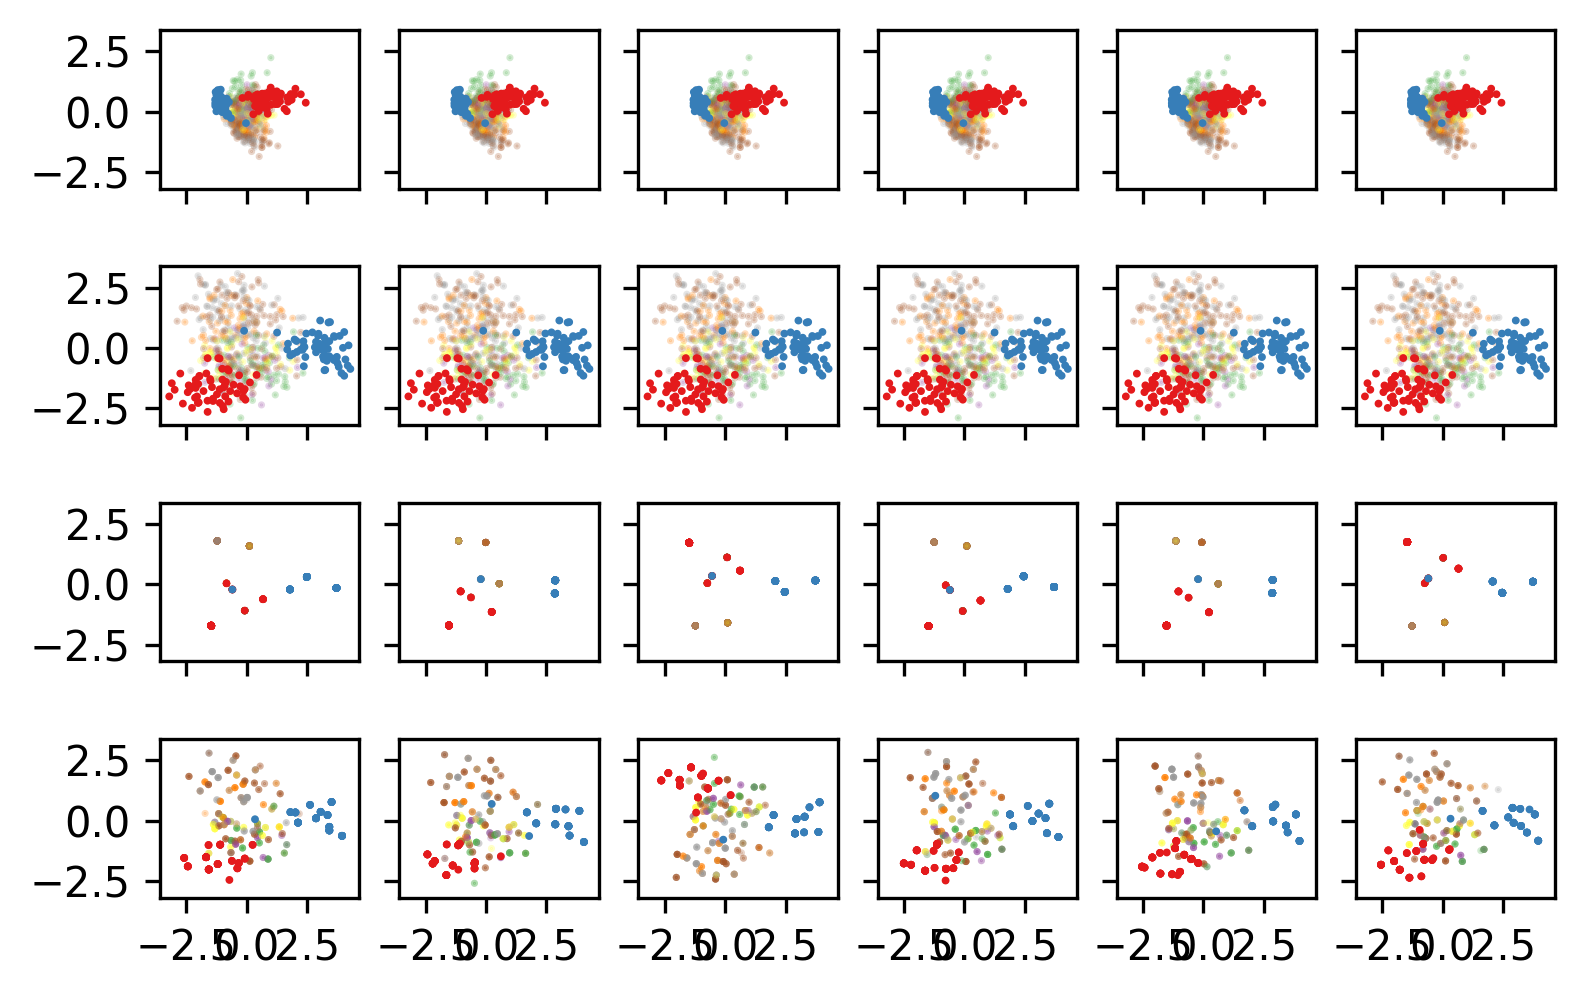

In [43]:
from rae.modules.attention import *
from tqdm import tqdm
import torch
from torch.optim.adam import Adam
from sklearn.decomposition import PCA
from scipy.stats import ortho_group

seed_everything(0)


def transform_latents(x, seed=0):
    opt_isometry, _ = TRANSFORMS[seed]

    noise = torch.randn_like(x) * 0.001
    o = x + noise
    o = o @ opt_isometry
    return o


LIM = 6
N_ROWS = 4
N_COLS = LIM

TRANSFORMS = [
    (
        torch.tensor(ortho_group.rvs(images_latents.shape[-1]), dtype=torch.float),
        torch.zeros(images_latents.shape[-1], dtype=torch.float),
    )
    for _ in range(LIM)
]

#plt.rcParams.update(bundles.icml2022())
#plt.rcParams.update(figsizes.icml2022_full(ncols=N_COLS, nrows=N_ROWS, height_to_width_ratio=1.0))

cmap = plt.cm.get_cmap("Set1", 10)
norm = plt.Normalize(min(targets), max(targets))


SHARE_X = True
SHARE_Y = True
DPI = 300

fig, [
    abs_axes,
    rel_axes,
    quant_axes1,
        quant_axes2,
] = plt.subplots(dpi=DPI, nrows=N_ROWS, ncols=N_COLS, sharey=SHARE_Y, sharex=SHARE_X, squeeze=True)


all_images_latents = [
    images_latents,
    *[transform_latents(images_latents, seed=idx) for idx in range(LIM - 1)],
]
all_anchors_latents = [
    anchors_latents,
    *[transform_latents(anchors_latents, seed=idx) for idx in range(LIM - 1)],
]


plot_row(
    abs_axes,
    [to_df(x) for x in all_images_latents],
)


dists_str = [f"AE; mean L2 dists: {latents_distance(all_images_latents)}"]

for axes, quant_mode, bin_size in (
    (rel_axes, None, None),
    (quant_axes1, AbsoluteQuantizationMode.KMEANS, 10),
    (quant_axes2, AbsoluteQuantizationMode.KMEANS, 100),
):
    rel_latents = []
    rel_attention = RelativeAttention(
        n_anchors=anchors_batch.shape,
        n_classes=len(set(targets)),
        similarity_mode=RelativeEmbeddingMethod.INNER,
        values_mode=ValuesMethod.SIMILARITIES,
        normalization_mode=NormalizationMode.L2,
        similarities_quantization_mode=quant_mode,
        similarities_num_clusters=bin_size,
        output_normalization_mode=None, #OutputNormalization.L2,
#         similarities_quantization_mode=quant_mode,
        similarities_bin_size=bin_size,
    )
    assert sum(x.numel() for x in rel_attention.parameters()) == 0

    rel_latents = [
        rel_attention(x=img_latents, anchors=a_latents)[AttentionOutput.SIMILARITIES]
        for (img_latents, a_latents) in zip(all_images_latents, all_anchors_latents)
    ]
    plot_row(
        axes,
        [to_df(x) for x in rel_latents],
    )
    dists_str.append(f"Att, bin size: {bin_size}; mean L2 dists: {latents_distance(rel_latents)}")
dists_str

In [20]:
fig.savefig("epsisometry.svg", bbox_inches="tight")
!rsvg-convert -f pdf -o 'epsisometry.pdf' 'epsisometry.svg'
!rm 'epsisometry'.svg

/bin/bash: line 1: rsvg-convert: command not found


In [44]:
images_latents.shape

torch.Size([512, 500])

In [64]:
(images_latents - (images_latents + torch.randn_like(images_latents) * 0.01)).mean(0).mean(0)

tensor(1.7753e-05)

In [68]:
torch.nn.functional.pairwise_distance(images_latents, images_latents + torch.randn_like(images_latents) * 0.001).mean()

tensor(0.0224)

In [ ]:
from sklearn.cluster import KMeans
absolute_num_clusters = 10
x=images_latents
anchors=anchors_latents

kmeans = KMeans(n_clusters=absolute_num_clusters, random_state=0)
kmeans.fit(torch.cat([x, anchors]).detach().cpu().numpy())

x = torch.as_tensor(kmeans.cluster_centers_[kmeans.predict(x.detach().cpu().numpy())])
anchors = torch.as_tensor(kmeans.cluster_centers_[kmeans.predict(anchors.detach().cpu().numpy())])

In [ ]:
kmeans.cluster_centers_[kmeans.labels_] 

In [ ]:
kmeans.cluster_centers_.shape